# Recursive instances

**This is only working with the 'restruct' signal kernel**

## Parity example

This example performs a parity check by *divide et impera*:

A parity check can be implemented in a self-recursing way until a certain condition is met (for bit vectors of power of two sizes). This achieves the same as a `reduce XOR` operation and is left here for reference only for procedural instancing tests.

In [1]:
NBITS_POWER = 4 # Configure this
USE_LOCAL_BRANCH = True

In [2]:
if USE_LOCAL_BRANCH:
    import sys
    sys.path.insert(0, "/home/pyosys/src/myhdl/myhdl-local")

from myhdl import *
import time

In [3]:
@block
def xor(a, b, q):
    @always_comb
    def worker():
        q.next = a ^ b
        
    return instances()

### Case without shadow signals

Parity check of one bit field without using ShadowSignals

In [4]:
@block
def parity1(a, q, DIRECT_OUT = True):
    N = len(a)
    q0, q1 = [ Signal(bool()) for i in range(2) ]
    
    if N > 2:

        M = N // 2
        ah, al = [ Signal(intbv()[M:]) for i in range(2) ]

        p0 = parity1(al, q0, DIRECT_OUT)
        p1 = parity1(ah, q1, DIRECT_OUT)

        @always_comb
        def assign():
            ah.next = a[M:]
            al.next = a[:M]
    else:
        @always_comb
        def assign():
            q0.next = a[0]
            q1.next = a[1]
        
    if DIRECT_OUT:
        p = q
    else:
        p = Signal(bool())
        @always_comb
        def assign_out():
            q.next = p
    
    inst = xor(q0, q1, p)

    return instances()


## Non-converting cases

These are not translating correctly in myhdl 'upstream'.


### Variant using shadow signals

This one is special, (might occasionally working using 'upstream'), using slice signals `ah` and `al`.
The random behaviour is due to the random order of signal analysis in the recursive hierarchy.

In [5]:
@block
def parity_shadow(a, q, DUMMY_PARAM = None):
    N = len(a)
    q0, q1 = [ Signal(bool()) for i in range(2) ]

    if N > 2:

        M = N // 2
        ah, al = a(N, M), a(M, 0)
        p0 = parity_shadow(al, q0)
        p1 = parity_shadow(ah, q1)

    else:
        @always_comb
        def assign():
            q0.next = a[0]
            q1.next = a[1]

    inst = xor(q0, q1, q)
    
    return instances()

### The fully shadow signal based variant

In [6]:
@block
def parity_shadow1(a, q, DUMMY_PARAM = None):
    N = len(a)

    if N > 2:
        q0, q1 = [ Signal(bool()) for i in range(2) ]
        M = N // 2
        ah, al = a(N, M), a(M, 0)
        p0 = parity_shadow1(al, q0)
        p1 = parity_shadow1(ah, q1)

    else:
        q0, q1 = a(0), a(1)

    inst = xor(q0, q1, q)
    
    return instances()

## Performance test

In [7]:
def convert(unit):
    a  = Signal(intbv()[2 ** NBITS_POWER:])
    q = Signal(bool())
    uut = unit(a, q)
    print(30 * '*')
    uut.name = uut.func.__name__ # Hack to resolve tb_*.v uuts correctly
    print("Output verilog for '%s'" % uut.name)
    uut.convert("verilog")

for unit in parity1, parity_shadow, parity_shadow1:
    t0 = time.process_time()
    convert(unit)
    print(time.process_time()-t0)


******************************
Output verilog for 'parity1'
3.602984332
******************************
Output verilog for 'parity_shadow'
3.530210879
******************************
Output verilog for 'parity_shadow1'
3.167110621999999


/home/pyosys/src/myhdl/myhdl-local/myhdl/conversion/_toVerilog.py:312: ToVerilogWarning: Port is not used: a
  category=ToVerilogWarning


In [8]:
! ls *.v

bram_mapped.v			     tb_mac_mapped.v
dpram_mapped.v			     tb_parity1.v
mac_mapped.v			     tb_parity1_mapped.v
parity1.v			     tb_parity_shadow.v
parity_shadow.v			     tb_parity_shadow1.v
parity_shadow1.v		     tb_rom1_mapped.v
rom1_mapped.v			     tb_simple_signal_mapped.v
simple_signal_mapped.v		     tb_simple_variable_mapped.v
simple_variable_mapped.v	     tb_test_mapped.v
tb_barrel_shifter_mapped.v	     tb_toplevel_mapped.v
tb_bitflip_test_mapped.v	     tb_ts_mapped.v
tb_bram_2psync_mapped.v		     tb_uart_translator_mapped.v
tb_complex_slicing_example_mapped.v  tb_unit_mapped.v
tb_dpram_mapped.v		     tb_uut_mapped.v
tb_ecp5test_mapped.v		     ts_mapped.v
tb_fifobuffer_mapped.v		     uart_translator_mapped.v
tb_gray_counter_mapped.v


# Co-Simulation

This code creates a wrapper around the verilog variant:

In [9]:
from ys_aux import setupCosimulation

@block
def verilog_wrapper(uut, a, q):
    "Cosimulation object for verilog output"
    args = locals()
    name = uut.func.__name__
    del args['uut']

    return setupCosimulation(name, False, args)


### Test bench

In [10]:
! rm *.vcd

In [11]:
values = [ 0xaa, 0xff, 0x13, 0x15 ]

def reduce_xor(v):
    val = False
    for i in range(len(v)):
        val = val ^ v[i]
    return val

@block
def testbench(units, DIRECT_OUT):
    v = Signal(intbv()[8:])
    
    nunits = len(units)
    
    q = [ Signal(bool()) for i in range(nunits)]
    q_v = [ Signal(bool()) for i in range(nunits)]
    
    
    uuts = []
    for i, u in enumerate(units):
        uuts.append(u(v, q[i], DIRECT_OUT))

    # Generate co-sim units in parallel:
    uuts_verilog = []
    for i, u in enumerate(units):
        uuts_verilog.append(verilog_wrapper(u, v, q_v[i]))
    
    @instance
    def stim():
        for val in values:
            v.next = val
            yield delay(20)
            for i in range(nunits):
                ref = reduce_xor(v)
                if q[i] != q_v[i] or q[i] != ref:
                    print("MyHDL: %s  -- Verilog: %s, Reference: %s"% (q[i], q_v[i], ref))
                    raise ValueError("Simulation mismatch")
                else:
                    print(bin(val), q, ref)

        raise StopSimulation
            
    return instances()

In [12]:
tb = testbench([parity1], False) # Working in upstream
# tb = testbench([parity1, parity_shadow1, parity_shadow]) # Only in PyriteHDL

tb.config_sim(backend = 'myhdl', timescale="1ps", trace=True)
tb.run_sim()
tb.quit_sim()

10101010 [Signal(False)] False
11111111 [Signal(False)] False
10011 [Signal(True)] True
10101 [Signal(True)] True


In [13]:
! ls *.vcd

testbench.vcd


## Synthesis

Problem: Due to recursiveness, the interface is not a priori resolved.
This is a pretty efficient test to point out signal direction issues within the hierarchy resolving.

In [14]:
from myhdl.conversion import yshelper

def convert(unit):
    a = Signal(intbv()[8:])
    q = Signal(bool())
    
    design = yshelper.Design("parity_test")
    uut = unit(a, q, False) # Use 'True' for direct output
    
    uut.convert("yosys_module", design)
    
    return design

# d = convert(parity_shadow1) # Broken in myhdl
d = convert(parity1)


Adding module with name: xor_1_1_1
CONVERT_RTL tree >>>>>> 'PARITY1_PARITY1_8_0_PARITY1_9_0_XOR_7_0_1_2_WORKER' 
Adding module with name: parity1_2_1_c0
CONVERT_RTL tree >>>>>> 'PARITY1_PARITY1_8_0_PARITY1_9_0_ASSIGN' 
CONVERT_RTL tree >>>>>> 'PARITY1_PARITY1_8_0_PARITY1_9_0_ASSIGN_OUT' 
++++++++ xor_7_0_1_2: xor_1_1_1 (Module) ++++++++
Adding module with name: parity1_4_1_c0
CONVERT_RTL tree >>>>>> 'PARITY1_PARITY1_8_0_ASSIGN' 
CONVERT_RTL tree >>>>>> 'PARITY1_PARITY1_8_0_ASSIGN_OUT' 
++++++++ parity1_9_0: parity1_2_1_c0 (Module) ++++++++
++++++++ parity1_10_0: parity1_2_1_c0 (Cell) ++++++++
++++++++ xor_9_0_1_2: xor_1_1_1 (Cell) ++++++++
Adding module with name: parity1_8_1_c0
CONVERT_RTL tree >>>>>> 'PARITY1_ASSIGN' 
CONVERT_RTL tree >>>>>> 'PARITY1_ASSIGN_OUT' 
++++++++ parity1_8_0: parity1_4_1_c0 (Module) ++++++++
++++++++ parity1_11_0: parity1_4_1_c0 (Cell) ++++++++
++++++++ xor_13_0_1_2: xor_1_1_1 (Cell) ++++++++


Generating RTL image...
Display...


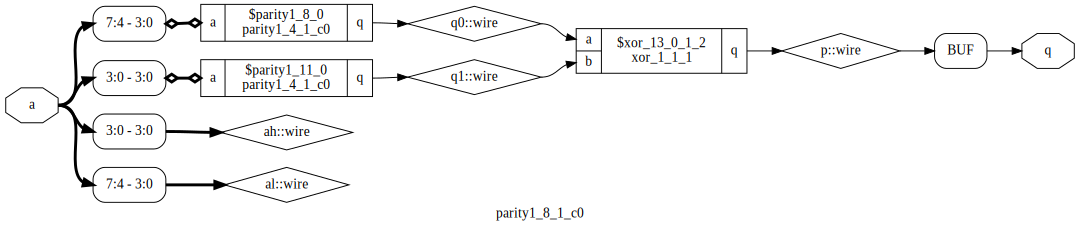

In [15]:
from ys_aux import to_svg
d.run("opt; clean ")

display(to_svg(d, "parity1_8_1_c0", 150))

Generating RTL image...
Display...


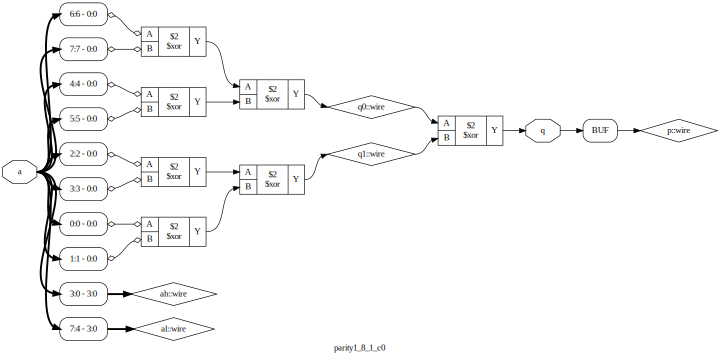

In [16]:
d.run("flatten; opt; clean")
display(to_svg(d, "", 100),)